In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from pyport.portopt import opt, objfunc
from pyport.portbt import PyBacktest
import pyport.portstats as stats

In [3]:
from pandas_datareader import data

In [4]:
"""Define parameters for data request."""

tickers = ['AGG', 'EBND', 'URTH', 'EEM']
data_source = 'yahoo'
start_date = '2014-03-31'
end_date = '2018-03-31'

In [5]:
"""Request data, ensure sorted by ascending date, and normalise."""

panel_data = data.DataReader(tickers, data_source, start_date, end_date)
px_data = panel_data.loc['Adj Close'].dropna().sort_index(ascending=True)
px_data = px_data / px_data.iloc[0]

In [6]:
"""
TEST CASE
Add constraints: Portfolio weights must sum to 100%, minimum ann. volatility target == 5.0%,
Add boundaries: Long only, no short positions.
"""

rf = 0.01
vol_trgt = 0.05

# cons = [
#     {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
#     {'type': 'eq', 'fun': lambda w: stats.vol(px_data, w) - vol_trgt}
# ]

cons = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
]

bnds = [(0, 1) for x in px_data.columns]

In [7]:
"""Run optimisation."""

opt_result = opt.port_optimisation(
    objfunc.max_dr, 
    px_data, rf=0.0, scaling_fact=252, conf_lvl=0.95, 
    constraints=cons, bounds=bnds
)

Optimization terminated successfully. Success==True after 10 iterations.
Total time: 0.1596512794494629 secs


In [8]:
"""View optimised weights."""

opt_result['weights']

array([ 0.75634013,  0.08231601,  0.00712816,  0.15421571])

In [9]:
"""Initialise backtest class."""

bt = PyBacktest(px_data, opt_period = 365, val_period = 90, rf=rf, scaling_fact=252)

In [10]:
"""Generate historical optimisation weights and create out-of-sample results / time series."""

equal_weights = bt.bt_optimisation(objfunc.equal_weights, constraints=cons, bounds=bnds)
equal_weights_ts = bt.bt_timeseries()

inv_volatility = bt.bt_optimisation(objfunc.inv_volatility, constraints=cons, bounds=bnds)
inv_volatility_ts = bt.bt_timeseries()

inv_variance = bt.bt_optimisation(objfunc.inv_variance, constraints=cons, bounds=bnds)
inv_variance_ts = bt.bt_timeseries()

max_er = bt.bt_optimisation(objfunc.max_er, constraints=cons, bounds=bnds)
max_er_ts = bt.bt_timeseries()

min_vol = bt.bt_optimisation(objfunc.min_vol, constraints=cons, bounds=bnds)
min_vol_ts = bt.bt_timeseries()

max_sr = bt.bt_optimisation(objfunc.max_sr, constraints=cons, bounds=bnds)
max_sr_ts = bt.bt_timeseries()

risk_parity = bt.bt_optimisation(objfunc.risk_parity, constraints=cons, bounds=bnds)
risk_parity_ts = bt.bt_timeseries()

max_dr = bt.bt_optimisation(objfunc.max_dr, constraints=cons, bounds=bnds)
max_dr_ts = bt.bt_timeseries()

min_mdd = bt.bt_optimisation(objfunc.min_mdd, constraints=cons, bounds=bnds)
min_mdd_ts = bt.bt_timeseries()

max_skew = bt.bt_optimisation(objfunc.max_skew, constraints=cons, bounds=bnds)
max_skew_ts = bt.bt_timeseries()

min_hVaR = bt.bt_optimisation(objfunc.min_hVaR, constraints=cons, bounds=bnds)
min_hVaR_ts = bt.bt_timeseries()

min_hcVaR = bt.bt_optimisation(objfunc.min_hcVaR, constraints=cons, bounds=bnds)
min_hcVaR_ts = bt.bt_timeseries()

Algorithm: equal_weights
Total time: 0.0101 secs

Algorithm: inv_volatility
Total time: 0.0156 secs

Algorithm: inv_variance
Total time: 0.019 secs

Algorithm: max_er
Total time: 0.4607 secs

Algorithm: min_vol
Total time: 0.6963 secs

Algorithm: max_sr
Total time: 1.0335 secs

Algorithm: risk_parity
Total time: 1.0883 secs

Algorithm: max_dr
Total time: 1.5158 secs

Algorithm: min_mdd
Total time: 1.1588 secs

Algorithm: max_skew
Total time: 0.8822 secs

Algorithm: min_hVaR
Total time: 1.0079 secs

Algorithm: min_hcVaR
Total time: 1.2728 secs



In [11]:
"""Create df of individual results."""

comp_df = pd.concat(
    [
        equal_weights_ts.MV,
        inv_volatility_ts.MV,
        inv_variance_ts.MV,
        max_er_ts.MV, 
        min_vol_ts.MV, 
        max_sr_ts.MV, 
        risk_parity_ts.MV, 
        max_dr_ts.MV, 
        min_mdd_ts.MV, 
        max_skew_ts.MV,
        min_hVaR_ts.MV,
        min_hcVaR_ts.MV
    ], 
    axis=1
)

comp_df.columns = [
    'equal_weights',
    'inv_volatility',
    'inv_variance',
    'max_er', 
    'min_vol', 
    'max_sr', 
    'risk_parity', 
    'max_dr', 
    'min_mdd',
    'max_skew',
    'min_hVaR',
    'min_cVaR'
]

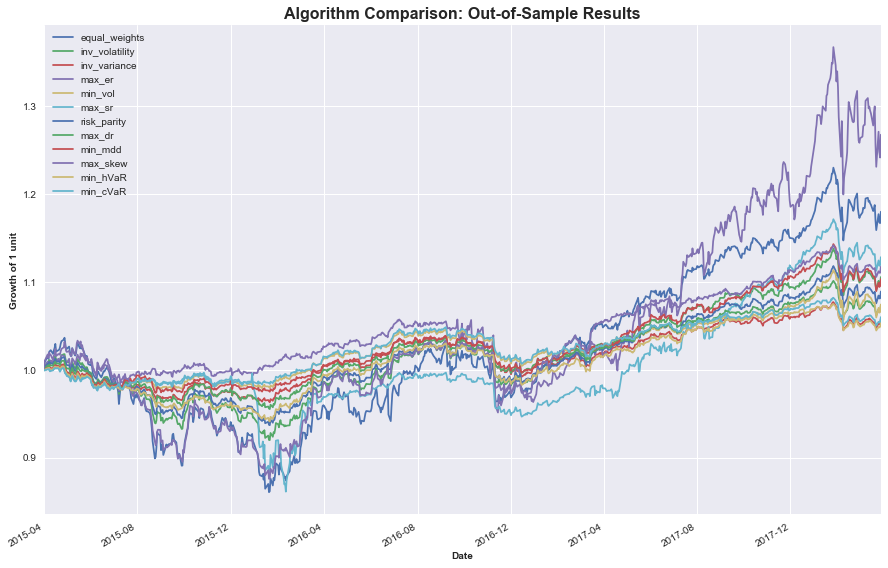

In [12]:
"""Plot and compare out-of-sample optimisation results."""

comp_df.plot(figsize=(15,10))
plt.title('Algorithm Comparison: Out-of-Sample Results', fontweight='bold', fontsize=16)
plt.ylabel('Growth of 1 unit', fontweight='bold', fontsize=10)
plt.xlabel('Date', fontweight='bold', fontsize=10)
plt.legend(loc='best');

In [13]:
"""View summary of out-of-sample statistics."""

res = stats.stats_summary(comp_df, rf=rf)
res

,equal_weights,inv_volatility,inv_variance,max_er,min_vol,max_sr,risk_parity,max_dr,min_mdd,max_skew,min_hVaR,min_cVaR
cumu_return,0.179772,0.105437,0.057878,0.267470,0.053963,0.128064,0.088960,0.073545,0.103091,0.117132,0.074185,0.059838
ann_return,0.056760,0.034041,0.018967,0.082369,0.017706,0.041062,0.028869,0.023982,0.033308,0.037682,0.024186,0.019597
volatility,0.094366,0.051903,0.031710,0.113897,0.029644,0.076291,0.042751,0.035273,0.037263,0.068430,0.040141,0.030114
sharpe_ratio,0.495522,0.463198,0.282783,0.635388,0.259957,0.407152,0.441359,0.396392,0.625495,0.404529,0.353394,0.318687
max_drawdown,-0.169669,-0.096165,-0.044916,-0.122696,-0.039755,-0.140811,-0.076366,-0.054703,-0.047500,-0.152280,-0.062499,-0.039634
skew,-0.578799,-0.501646,-0.486412,-0.612530,-0.407459,-0.731798,-0.493803,-0.507333,-0.979767,-0.122489,-1.106547,-0.470918
kurtosis,2.857537,2.182244,1.900632,6.448540,1.425646,10.822650,2.060537,2.103992,5.677451,2.636198,6.943514,1.528997


In [14]:
"""Approaches sorted by sharpe ratio."""

res.loc['sharpe_ratio'].sort_values(ascending=False)

max_er            0.635388
min_mdd           0.625495
equal_weights     0.495522
inv_volatility    0.463198
risk_parity       0.441359
max_sr            0.407152
max_skew          0.404529
max_dr            0.396392
min_hVaR          0.353394
min_cVaR          0.318687
inv_variance      0.282783
min_vol           0.259957
Name: sharpe_ratio, dtype: float64